In [1]:
from LSSTFringe import Sky_rubin as Sky  
from LSSTFringe import utils,plot_utils
import rubin_sim.utils.ObservationMetaData as ObsMeta 
import galsim
import warnings
import astropy.units as u
warnings.filterwarnings('ignore')
import numpy as np
plot_utils.init_plot_style()
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load thickness map and interpolator
Fitting,uu,indices = utils.load_ccd_map('E2V-321')
pfs_interpolator = utils.load_interp(experiment='LSST')
Normal_interpolator = utils.load_interp(experiment='Normal')
Mono_interpolator = utils.load_interp(experiment='Mono')

In [3]:
Obs_meta = ObsMeta(pointingRA=5.497787143782138,
                   pointingDec=-1.519759751642230,bandpassName='y',rotSkyPos=0)

model = Sky.Sky(ra=Obs_meta.pointingRA,dec = Obs_meta.pointingDec,Mjd=58000)  

# Split sky background into two components
upperatm_count,up_wlen,up_spec = model.Count_upper_atm()
contiuum_count = model.Count_sky_continuum()

photParams = model.Phot_par()
exposureTime = photParams.nexp*photParams.exptime

upper_count = upperatm_count*exposureTime
# Adding noise to sky background
randomNum = galsim.UniformDeviate()
noise = galsim.CCDNoise(randomNum,sky_level=0.0,gain=photParams.gain,read_noise=photParams.readnoise)

# Making a galsim image for sky bg & upper Atm
image_cont = np.ones(shape = (3974,4000))*contiuum_count*exposureTime
galsim_image_cont = galsim.Image(image_cont, copy=True)

image_UpperAtm = np.ones(shape = (3974,4000))*upperatm_count*exposureTime
galsim_image_UpperAtm = galsim.Image(image_UpperAtm, copy=True)

# Adding noise to images
galsim_image_cont.addNoise(noise)
galsim_image_UpperAtm.addNoise(noise)

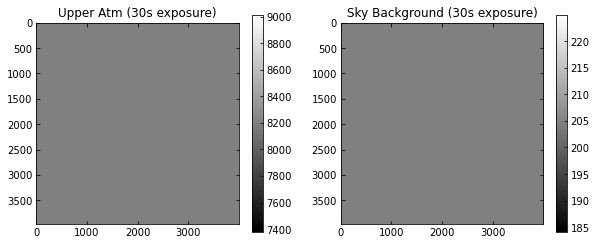

In [4]:
f,ax = plt.subplots(ncols=2,figsize =(10,4))
im1 = ax[0].imshow(image_UpperAtm,cmap='gray')
ax[0].set_title('Upper Atm (%is exposure)'%exposureTime)
im2 = ax[1].imshow(image_cont,cmap='gray')
ax[1].set_title('Sky Background (%is exposure)'%exposureTime)
f.colorbar(im1,ax=ax[0])
f.colorbar(im2,ax=ax[1]);

In [5]:
yband_QE = Sky.Sky().Bandpass()
yband = Sky.Sky().Bandpass()
detector = Sky.Sky().detector_throughputs()
yband.sb = yband.sb/detector
where_are_NaNs = isnan(yband.sb)
yband.sb[where_are_NaNs] = 0
mm = (yband.wavelen < 1100) & (yband.wavelen > 908)

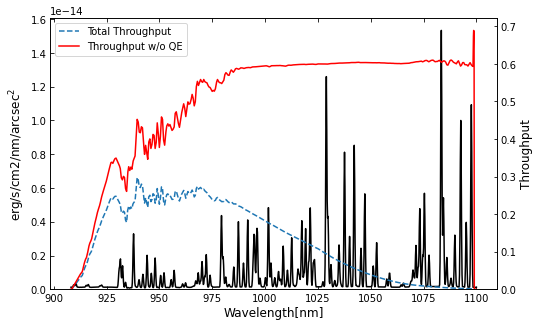

In [6]:
MM = (up_wlen < 1100) & (up_wlen > 908)
fig, ax1 = plt.subplots(nrows=1,sharex=True,figsize = (8,5))
ax2 = ax1.twinx()
ax1.plot(up_wlen[MM],up_spec[0][MM],'black')
#ax1.set_ylabel('Absorption in Silicon')
ax2.plot(yband.wavelen[mm],yband_QE.sb[mm],'--',label = 'Total Throughput')
ax2.plot(yband.wavelen[mm],yband.sb[mm],'r',label = 'Throughput w/o QE')
ax2.legend()
ax1.set_ylabel('erg/s/cm2/nm/arcsec$^2$',fontsize = 12)
ax2.set_ylabel('Throughput',fontsize = 12)
ax1.set_xlabel('Wavelength[nm]',fontsize = 12)
ax2.set_ylim(0,)
ax1.set_ylim(0,);

In [7]:
def line_under_bandpass (PFS = False,Skybrightness = False,verbose = True):
    
    detector = Sky.Sky().detector_throughputs()
    yband = Sky.Sky().Bandpass()
    
    yband.sb = yband.sb/detector
    where_are_NaNs = isnan(yband.sb)
    yband.sb[where_are_NaNs] = 0
    
    if PFS == True: 
    
        line_wlen,line_int,l =Sky.OHlines().load_skyline()
        _,group_dir = Sky.OHlines().get_grouping(l)
        mask = (line_wlen > 908) & (line_wlen < 1099)
        
        c = Sky.Conv(band_wlen=yband.wavelen,band_thr=yband.sb,line_wlen=line_wlen,line_int=line_int)
        intensity = c.conv()
        #line_intensity = intensity/np.sum(intensity)
        
        wavelengths = np.round(line_wlen[mask],1)
        #wavelengths = line_wlen[mask]
        line_intensity = intensity*wavelengths/np.sum(intensity*wavelengths)
        line_count = upper_count*line_intensity 
        
        if verbose == True:
            print(line_count.shape)
        
    if Skybrightness == True:
        
        m = (up_wlen > 908.3) & (up_wlen < 1098.8)

        c = Sky.Conv(band_wlen=yband.wavelen,band_thr=yband.sb,line_wlen=up_wlen[m],line_int=up_spec[0][m])
        intensity = c.conv()
        
        wavelengths = np.round(up_wlen[m],1)
        line_intensity = intensity*wavelengths/np.sum(intensity*wavelengths)
        line_count = upper_count*line_intensity   
        
        if verbose == True:
            print(line_count.shape)
    
    return(wavelengths,line_count)

def plot_line (wavelen, intensity , color):
    for i in range(len(wavelen)):
        plt.plot([wavelen[i],wavelen[i]],[0,intensity[i]],color = 'black')
    plt.ylim(0,)
    
# Define some plotting utility functions
def plot_tt_amp (sim_res,l):
    tt = sim_res #+ image_cont
    plt.plot(np.diag(tt/np.mean(tt)-1)*100,label = l)
    plt.legend(frameon = False,fontsize = 15)
    plt.axhline(0,ls = '--',color = 'black')
    plt.ylabel('Fringing amplitude (%)',fontsize = 15)
    plt.xlabel('Diagonal Pixel',fontsize = 15)

def plot_diag (sim):
    plt.plot((np.diag(sim)/np.mean(np.diag(sim))-1)*100)
    
def bg_image (sim_res,image_count = image_cont):
    galsim_image = galsim.Image(sim_res, copy=True)
    galsim_image.addNoise(noise)
    plt.imshow(galsim_image.array,cmap = 'gray',origin = 'lower')
    plt.colorbar()
    
    
def get_lh (data,clip_percent = 1):
    lo, hi = np.percentile(
        data.ravel(), (0.5 * clip_percent, 100 - 0.5 * clip_percent))
    return(lo,hi)

In [16]:
PFS_wavelengths, PFS_line_count = line_under_bandpass (PFS = True,verbose=False)

In [9]:
def sim (wavelengths,line_count,interp,angles,angle_weight):
    #sim_res = np.zeros(shape = Fitting.shape)
    sim_res = np.zeros(shape = (3974, 4000))
    for wlen,count_num in zip(wavelengths,line_count):
        int_f = interp[str(wlen)]
        ss = int_f(uu,angles)
        sst = ss.T
        total = np.sum(sst * angle_weight, axis = 1)
        #print(wlen,total)
        final = total[indices]
        sim_res += count_num*final.reshape(3974, 4000)
        #print(ss)
    return(sim_res)

In [10]:
# Incident angle distribution and corresponding weight
angles_center,weight_center = utils.get_angle(theta_x=0,theta_y=0.)
angles_edge,weight_edge = utils.get_angle(theta_x=1.2,theta_y=0.8)

# MonoCam angle distribution
th_min=0.1*u.deg 
th_max=7.13*u.deg

angles_mono = np.linspace(th_min.to(u.rad).value, th_max.to(u.rad).value, 100)
weight_mono = angles_mono / np.sum(angles_mono)

## First with MonoCam

In [13]:
mono_pfs = sim(wavelengths=PFS_wavelengths,line_count=PFS_line_count,interp= Mono_interpolator,
               angles = angles_mono, angle_weight=weight_mono)

Figure 13

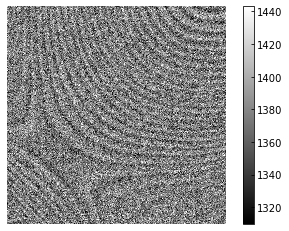

In [15]:
galsim_image = galsim.Image(mono_pfs*2+image_cont*2, copy=True)
galsim_image.addNoise(noise)

lo,hi = get_lh(galsim_image.array)

plt.imshow(galsim_image.array,cmap = 'gray',origin = 'lower',vmin = lo, vmax = hi,interpolation='nearest')
#plt.colorbar()

plt.axis('off')
plt.colorbar()
#plt.savefig('Paperplots/MonoCamimage.eps');

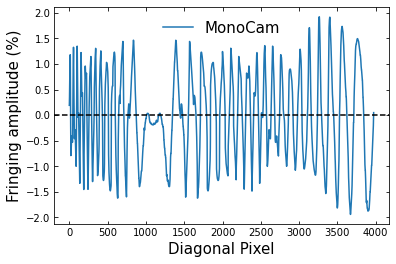

In [17]:
plot_tt_amp(mono_pfs,l = 'MonoCam')
plt.xlabel('Diagonal Pixel')
plt.savefig('Paperplots/MonoCam_sims.eps')

## Then with LSST cam

In [11]:
sim_pfs_center = sim(wavelengths=PFS_wavelengths,line_count=PFS_line_count,
                     interp= pfs_interpolator,angles = angles_center, angle_weight=weight_center)

In [12]:
sim_pfs_edge = sim(wavelengths=PFS_wavelengths,line_count=PFS_line_count,
                   interp= pfs_interpolator,angles = angles_edge, angle_weight=weight_edge)

Figure 15

Text(0.5, 0, 'Diagonal pixel')

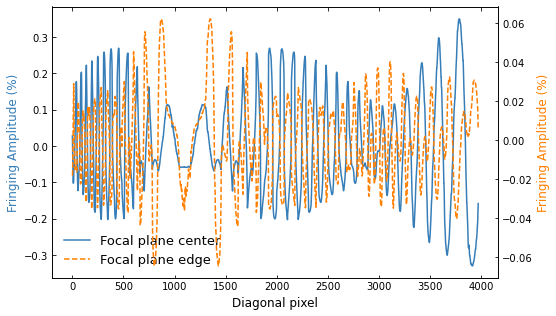

In [19]:
ax1_c = '#377eb8'
ax2_c =  '#ff7f00'

fig, ax1 = plt.subplots(nrows=1,sharex=True,figsize = (8,5))
lns = ax1.plot()
ax2 = ax1.twinx()
g1 = np.mean(np.diag(sim_pfs_center))
lns += ax1.plot((np.diag(sim_pfs_center)/g1-1)*100,color = ax1_c,label = 'Focal plane center')
g2 = np.mean(np.diag(sim_pfs_edge))
lns += ax2.plot((np.diag(sim_pfs_edge)/g2-1)*100,'--',color = ax2_c,label = 'Focal plane edge')

#ax2.spines['left'].set_color(ax1_c)
#ax2.legend(frameon = False,fontsize= 12,loc = 'best')
#ax1.legend(frameon = False,fontsize = 12,loc = 'best')
ax1.set_ylabel('Fringing Amplitude (%)',fontsize = 12)
ax2.set_ylabel('Fringing Amplitude (%)',fontsize = 12)

labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='best',frameon = False,fontsize = 13)

#ax2.spines['right'].set_color(ax2_c)
ax2.yaxis.label.set_color(ax2_c)
ax1.yaxis.label.set_color(ax1_c)
#ax1.tick_params(axis='y', colors= ax1_c)
#ax2.tick_params(axis='y',colors = ax2_c)
ax1.set_xlabel('Diagonal pixel',fontsize = 12)
#fig.savefig('Paperplots/LSST-fringe-sims.eps')

## LSST sky bg simulation

Figure 16 & 17

In [24]:
def photon_to_mag (photon_num):
    k_y = 0.169504
    x = 1.2
    zp_y = 26.65798980004943
    return(-2.5*np.log10(photon_num*photParams.gain/(photParams.platescale**2*(photParams.exptime*2)))
           + zp_y) #- k_y * x)

import rubin_sim.photUtils.PhotometricParameters as phopara
def Nphoto_2_Jy (number_photon):
    a = phopara(bandpass='y')
    A = a.effarea/(100*100) # Area in m^2
    t = a.exptime*2
    R = 4.462
    
    S_mu = number_photon / ((15.0919/R) * t * A) / a.platescale**2
    
    return(S_mu)

In [18]:
#from skimage.filters import difference_of_gaussians, window
from scipy.fftpack import fftn, fftshift
from scipy.ndimage import gaussian_filter,gaussian_laplace
from mpl_toolkits.axes_grid1 import make_axes_locatable

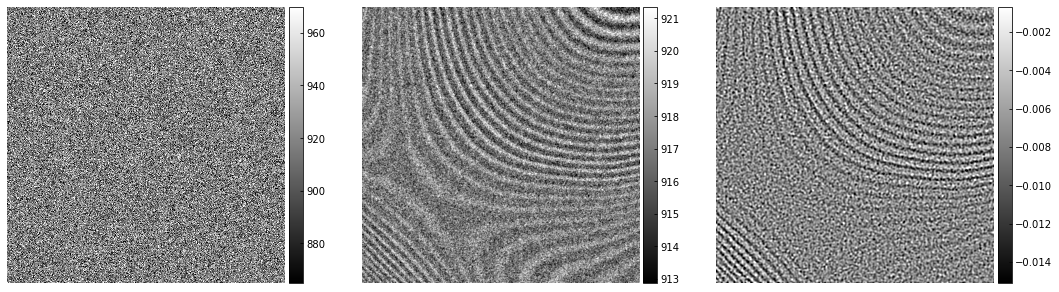

In [22]:
galsim_image = galsim.Image(sim_pfs_center+image_cont, copy=True)
galsim_image.addNoise(noise)

f,ax = plt.subplots(1,3,figsize = (18,6))
lo,hi = get_lh(galsim_image.array)
im1 = ax[0].imshow(galsim_image.array,cmap = 'gray',
                   origin = 'lower',vmin = lo, vmax = hi,interpolation='nearest')
A_g = gaussian_filter(galsim_image.array, sigma=4)

ax[0].axis('off')
divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)

lo,hi = get_lh(A_g)
im2 = ax[1].imshow(A_g,cmap = 'gray',origin = 'lower',vmin = lo, vmax = hi)
ax[1].axis('off')
divider = make_axes_locatable(ax[1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)

A_lap = gaussian_laplace(galsim_image.array, sigma=15)
lo,hi = get_lh(A_lap)
im3 = ax[2].imshow(A_lap,cmap = 'gray',origin = 'lower',vmin = lo, vmax = hi)
ax[2].axis('off')
divider = make_axes_locatable(ax[2])
cax3 = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(mappable=im1,cax=cax1)
f.colorbar(mappable=im2,cax=cax2)
f.colorbar(mappable=im3,cax=cax3)
#f.savefig('Paperplots/LSST-skybg-image.eps')

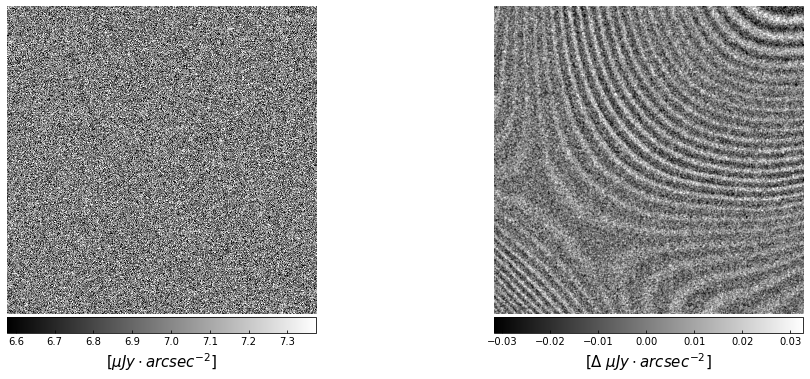

In [25]:
f,ax = plt.subplots(1,2,figsize = (16,6))
#image_mag = photon_to_mag(galsim_image.array)
image_mag = Nphoto_2_Jy(galsim_image.array)
lo,hi = get_lh(image_mag)
im1 = ax[0].imshow(image_mag,cmap = 'gray',origin = 'lower',interpolation='nearest',vmin = lo, vmax = hi)


A_g = gaussian_filter(galsim_image.array, sigma=4)
#image_gauss_mag = photon_to_mag(A_g)
image_gauss_mag = Nphoto_2_Jy(A_g)
ax[0].axis('off')
divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.05)

lo,hi = get_lh((image_gauss_mag-np.mean(image_gauss_mag)))
#lo,hi = get_lh(image_gauss_mag)
#im2 = ax[1].imshow(image_gauss_mag,cmap = 'gray',origin = 'lower',vmin = lo, vmax = hi)
im2 = ax[1].imshow((image_gauss_mag-np.mean(image_gauss_mag)),cmap = 'gray',origin = 'lower',vmin = lo, vmax = hi)
#A_gs = -2.5*np.log10(A_g/(photParams.platescale*(photParams.exptime*2))) + 26.65798980004943
#lo,hi = get_lh(A_gs)
#im2 = ax[1].imshow(A_gs,cmap = 'gray',origin = 'lower',vmin = lo, vmax = hi)
ax[1].axis('off')
divider = make_axes_locatable(ax[1])
cax2 = divider.append_axes("bottom", size="5%", pad=0.05)
#A_lap = gaussian_laplace(galsim_image.array, sigma=15)
#lo,hi = get_lh(A_lap)
#im3 = ax[2].imshow(A_lap,cmap = 'gray',origin = 'lower',vmin = lo, vmax = hi)
#ax[2].axis('off')
#divider = make_axes_locatable(ax[2])
#cax3 = divider.append_axes("right", size="5%", pad=0.05)
cbar1 = f.colorbar(mappable=im1,cax=cax1,orientation="horizontal")
cbar2 = f.colorbar(mappable=im2,cax=cax2,orientation="horizontal")
#cbar1.set_label(r'$\mu$'+ r' [mag/arcsec$^2$]',size=15)
#cbar2.set_label(r'$\Delta\mu$ [mmag/arcsec$^2$]',size=15);
cbar1.set_label(r'$[\mu Jy\cdot arcsec^{-2}$]',size=15)
cbar2.set_label(r'$[\Delta\ \mu Jy\cdot arcsec^{-2}$]',size=15);
#f.savefig('Paperplots/LSST-skybg-mag-image.eps')
#f.colorbar(mappable=im3,cax=cax3)